In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import tensorflow_hub as hub
from bert.tokenization import FullTokenizer

from tqdm import tqdm_notebook
from IPython.display import Image 
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [4]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [5]:
def plot_confusion_matrix(f1,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          i=1):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    plt.figure(figsize=(10, 6))
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1-score={:0.4f}'.format(accuracy, misclass, f1))

In [6]:
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [8]:
UD_HINDI_TRAIN = 'hi_hdtb-ud-train.conllu'
UD_HINDI_DEV = 'hi_hdtb-ud-dev.conllu'
UD_HINDI_TEST = 'hi_hdtb-ud-test.conllu'

In [9]:
def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos and token.form:
                t+=1
                tagged_sentence.append((token.form.lower(), token.upos))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

In [12]:
train_sentences = read_conllu(UD_HINDI_TRAIN)
val_sentences = read_conllu(UD_HINDI_DEV)
test_sentences = read_conllu(UD_HINDI_TEST)


In [13]:
print("Tagged sentences in train set: ", len(train_sentences))
print("Tagged words in train set:", len([item for sublist in train_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in dev set: ", len(val_sentences))
print("Tagged words in dev set:", len([item for sublist in val_sentences for item in sublist]))
print(40*'=')
print("Tagged sentences in test set: ", len(test_sentences))
print("Tagged words in test set:", len([item for sublist in test_sentences for item in sublist]))
print(40*'*')
print("Total sentences in dataset:", len(train_sentences)+len(val_sentences)+len(test_sentences))


Tagged sentences in train set:  13304
Tagged words in train set: 281057
Tagged sentences in dev set:  1659
Tagged words in dev set: 35217
Tagged sentences in test set:  1684
Tagged words in test set: 35430
****************************************
Total sentences in dataset: 16647


In [14]:
print(train_sentences[0])


[('यह', 'DET'), ('एशिया', 'PROPN'), ('की', 'ADP'), ('सबसे', 'ADV'), ('बड़ी', 'ADJ'), ('मस्जिदों', 'NOUN'), ('में', 'ADP'), ('से', 'ADP'), ('एक', 'NUM'), ('है', 'AUX'), ('।', 'PUNCT')]


In [15]:
def tag_sequence(sentences):
    return [[t for w, t in sentence] for sentence in sentences]

def text_sequence(sentences):
    return [[w for w, t in sentence] for sentence in sentences]

In [16]:

tags = set([item for sublist in train_sentences+test_sentences+val_sentences for _, item in sublist])
print('TOTAL TAGS: ', len(tags))

TOTAL TAGS:  16


In [21]:

tag2int = {}
int2tag = {}

for i, tag in enumerate(sorted(tags)):
    tag2int[tag] = i+1
    int2tag[i+1] = tag


In [22]:

# Special character for the tags
tag2int['-PAD-'] = 0
int2tag[0] = '-PAD-'

In [23]:
n_tags = len(tag2int)
print('Total tags:', n_tags)

Total tags: 17


In [24]:
list(tag2int)


['ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'VERB',
 'X',
 '-PAD-']

In [26]:
MAX_SEQUENCE_LENGTH = 70
EPOCHS = 30

In [27]:
train_sentences = read_conllu(UD_HINDI_TRAIN)
val_sentences = read_conllu(UD_HINDI_DEV)
test_sentences = read_conllu(UD_HINDI_TEST)


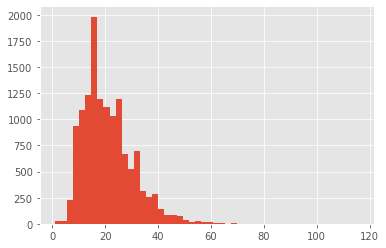

In [28]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

In [29]:
print('Max sentence length:',len(max(train_sentences+val_sentences, key=len)))


Max sentence length: 116


In [30]:
def  split(sentences, max):
    new=[]
    for data in sentences:
        new.append(([data[x:x+max] for x in range(0, len(data), max)]))
    new = [val for sublist in new for val in sublist]
    return new

In [31]:
train_sentences = split(train_sentences, MAX_SEQUENCE_LENGTH)
val_sentences = split(val_sentences, MAX_SEQUENCE_LENGTH)
test_sentences = split(test_sentences, MAX_SEQUENCE_LENGTH)

In [32]:
len(max(train_sentences+val_sentences, key=len))


70

In [33]:
train_sentences = train_sentences + val_sentences


In [34]:
# Initialize session
sess = tf.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

In [35]:
train_text = text_sequence(train_sentences)
test_text = text_sequence(test_sentences)
#val_text = text_sequence(val_sentences)

train_label = tag_sequence(train_sentences)
test_label= tag_sequence(test_sentences)
#val_label= tag_sequence(val_sentences)


In [36]:
len(train_text)


14969

In [37]:
train_text[0], train_label[0]


(['यह',
  'एशिया',
  'की',
  'सबसे',
  'बड़ी',
  'मस्जिदों',
  'में',
  'से',
  'एक',
  'है',
  '।'],
 ['DET',
  'PROPN',
  'ADP',
  'ADV',
  'ADJ',
  'NOUN',
  'ADP',
  'ADP',
  'NUM',
  'AUX',
  'PUNCT'])

In [38]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.
  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label_ids = [0] * max_seq_length
        return input_ids, input_mask, segment_ids, label_ids
    
    tokens_a = example.text_a
    if len(tokens_a) > max_seq_length-2:
        tokens_a = tokens_a[0 : (max_seq_length-2)]

# Token map will be an int -> int mapping between the `orig_tokens` index and
# the `bert_tokens` index.

# bert_tokens == ["[CLS]", "john", "johan", "##son", "'", "s", "house", "[SEP]"]
# orig_to_tok_map == [1, 2, 4, 6]   
    orig_to_tok_map = []              
    tokens = []
    segment_ids = []
    
    tokens.append("[CLS]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    #print(len(tokens_a))
    for token in tokens_a:       
        tokens.extend(tokenizer.tokenize(token))
        orig_to_tok_map.append(len(tokens)-1)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)
    orig_to_tok_map.append(len(tokens)-1)
    input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])
    #print(len(orig_to_tok_map), len(tokens), len(input_ids), len(segment_ids)) #for debugging

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)
    
    label_ids = []
    labels = example.label
    label_ids.append(0)
    label_ids.extend([tag2int[label] for label in labels])
    label_ids.append(0)
    #print(len(label_ids)) #for debugging
    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)
        label_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length
    assert len(label_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, label_ids

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text, text_b=None, label=label)
        )
    return InputExamples

In [39]:
tokenizer = create_tokenizer_from_hub_module()


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [40]:
def bert_labels(labels):
    train_label_bert = []
    train_label_bert.append('-PAD-')
    for i in labels:
        train_label_bert.append(i)
    train_label_bert.append('-PAD-')
    print('BERT labels:', train_label_bert)

In [41]:
tokens_a = train_text[2]

In [42]:
orig_to_tok_map = []              
tokens = []
segment_ids = []
tokens.append("[CLS]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
for token in tokens_a:
    #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
    tokens.extend(tokenizer.tokenize(token))
    orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
    segment_ids.append(0)
tokens.append("[SEP]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])

In [43]:
print('Original tokens:',tokens_a)


Original tokens: ['इसका', 'प्रवेश', 'द्वार', 'दो', 'मंजिला', 'है', '।']


In [44]:
print('BERT tokens:',tokens)


BERT tokens: ['[CLS]', '[UNK]', 'प', '##र', '##व', '##श', 'द', '##व', '##ा', '##र', 'द', '##ो', 'म', '##ज', '##ि', '##ल', '##ा', 'ह', '।', '[SEP]']


In [45]:
bert_labels(train_label[2])


BERT labels: ['-PAD-', 'PRON', 'NOUN', 'NOUN', 'NUM', 'ADJ', 'AUX', 'PUNCT', '-PAD-']


In [46]:
orig_to_tok_map


[0, 1, 5, 9, 11, 16, 17, 18, 19]

In [47]:

"""Create InputExamples"""
InputExamples = []
for text, label in zip(train_text[0:1], train_label[0:1]):
    InputExamples.append(
        InputExample(guid=None, text_a=text, text_b=None, label=label)
)

In [48]:
input_ids, input_masks, segment_ids, labels = [], [], [], []
for example in tqdm_notebook(InputExamples, desc="Converting examples to features"):
    input_id, input_mask, segment_id, label = convert_single_example(
        tokenizer, example, MAX_SEQUENCE_LENGTH+2
    )
    input_ids.append(input_id)
    input_masks.append(input_mask)
    segment_ids.append(segment_id)
    labels.append(label)

/home/tushar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [49]:

# Convert data to InputExample format
train_examples = convert_text_to_examples(train_text, train_label)
test_examples = convert_text_to_examples(test_text, test_label)

In [50]:
(train_input_ids, train_input_masks, train_segment_ids, train_labels_ids
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)
(test_input_ids, test_input_masks, test_segment_ids, test_labels_ids
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_SEQUENCE_LENGTH+2)

/home/tushar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:108: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [51]:

print(len(train_input_ids[0]))
print(len(train_input_masks[0]))
print(len(train_segment_ids[0]))
print(len(train_labels_ids[0]))

72
72
72
72


In [52]:
train_input_ids[0]


array([  101, 29875, 29876, 29878, 29874, 29878, 29879,  1331,  1338,
       29851,  1339,  1344,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0])

In [53]:
train_input_masks[0]


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [54]:
train_segment_ids[0]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [55]:
train_labels_ids[0]


array([ 0,  6, 12,  2,  3,  1,  8,  2,  2,  9,  4, 13,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0])

In [56]:
train_labels = to_categorical(train_labels_ids, num_classes=n_tags)
test_labels = to_categorical(test_labels_ids, num_classes=n_tags)


In [57]:
train_input_ids[0], train_labels[0]


(array([  101, 29875, 29876, 29878, 29874, 29878, 29879,  1331,  1338,
        29851,  1339,  1344,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0]),
 array([[1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [58]:
class BertLayer(Layer):
    def __init__(self, output_representation='sequence_output', trainable=True, **kwargs):
        self.bert = None
        super(BertLayer, self).__init__(**kwargs)
        
        self.trainable = trainable
        self.output_representation = output_representation

    def build(self, input_shape):
        # SetUp tensorflow Hub module
        self.bert = hub.Module(bert_path,
                               trainable=self.trainable, 
                               name="{}_module".format(self.name))

        # Assign module's trainable weights to model
        # Remove unused layers and set trainable parameters
        # s = ["/cls/", "/pooler/", 'layer_11', 'layer_10', 'layer_9', 'layer_8', 'layer_7', 'layer_6']
        s = ["/cls/", "/pooler/"]
        self.trainable_weights += [var for var in self.bert.variables[:] if not any(x in var.name for x in s)]
            
        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)
                
        # See Trainable Variables
        #tf.logging.info("**** Trainable Variables ****")
        #for var in self.trainable_weights:
        #    init_string = ", *INIT_FROM_CKPT*"
        #    tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape, init_string)
            
        print('Trainable weights:',len(self.trainable_weights))
        super(BertLayer, self).build(input_shape)

    def call(self, inputs, mask=None):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
            self.output_representation
        ]
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs[0], 0.0)   

    def compute_output_shape(self, input_shape):
        if self.output_representation == 'pooled_output':
            return (None, 768)
        else:
            return (None, None, 768)

In [59]:
# Build model
def build_model(max_seq_length):
    seed = 0 
    in_id = keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    np.random.seed(seed)
    bert_output = BertLayer()(bert_inputs)

    np.random.seed(seed)
    outputs = keras.layers.Dense(n_tags, activation=keras.activations.softmax)(bert_output)

    np.random.seed(seed)
    model = keras.models.Model(inputs=bert_inputs, outputs=outputs)
    np.random.seed(seed)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.00004), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])   
    model.summary(100)
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [60]:
model = build_model(MAX_SEQUENCE_LENGTH+2) # We sum 2 for [CLS], [SEP] tokens


Trainable weights: 197
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_ids (InputLayer)           (None, 72)            0                                            
____________________________________________________________________________________________________
input_masks (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
segment_ids (InputLayer)         (None, 72)            0                                            
____________________________________________________________________________________________________
bert_layer_1 (BertLayer)         (None, None, 768)     110104890   input_ids[0][0]                  
                                                                   input_masks[0][0]       

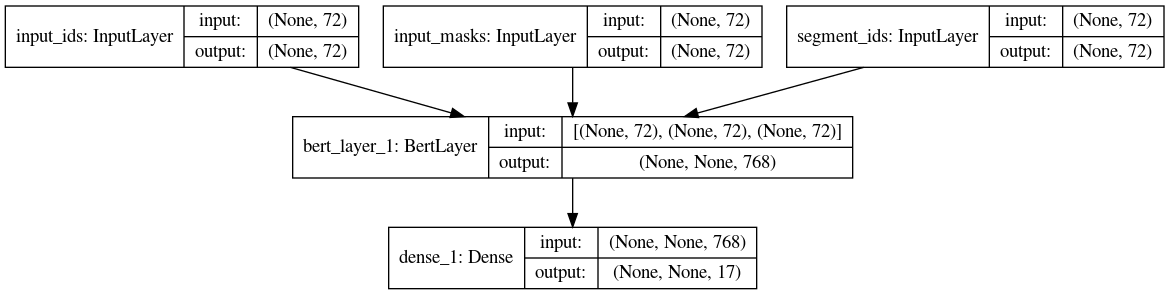

In [63]:
plot_model(model, to_file='model.png', show_shapes=True)
Image('model.png')


In [64]:
train_input_ids.shape


(14969, 72)

In [65]:
train_input_masks.shape


(14969, 72)

In [66]:
train_segment_ids.shape


(14969, 72)

In [67]:
train_labels.shape


(14969, 72, 17)

In [68]:
initialize_vars(sess)


In [69]:
t_ini = datetime.datetime.now()

cp = ModelCheckpoint(filepath="bert_tagger.h5",
                     monitor='val_acc',
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=1)

early_stopping = EarlyStopping(monitor = 'val_acc', patience = 5)

history = model.fit([train_input_ids, train_input_masks, train_segment_ids], 
                    train_labels,
                    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
                    #validation_split=0.3,
                    epochs=EPOCHS,
                    batch_size=16,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, early_stopping]
                   ) 

t_fin = datetime.datetime.now()
print('Training completed in {} seconds'.format((t_fin - t_ini).total_seconds()))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/home/tushar/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 14969 samples, validate on 1684 samples
Epoch 1/30



   64/14969 [..............................] - ETA: 25:27:22 - loss: 2.5139 - acc: 0.1935

KeyboardInterrupt: 

In [ ]:
model = build_model(MAX_SEQUENCE_LENGTH+2) 
model.load_weights('bert_tagger.h5')

In [ ]:
y_pred = model.predict([test_input_ids, test_input_masks, test_segment_ids]).argmax(-1)
y_true = test_labels.argmax(-1)

In [ ]:
y_true[0]


In [ ]:
def y2label(zipped, mask=0):
    out_true = []
    out_pred = []
    for zip_i in zipped:
        a, b = tuple(zip_i)
        if a != mask :
            out_true.append(int2tag[a])
            out_pred.append(int2tag[b])
    return out_true, out_pred

In [ ]:
y_zipped = zip(y_true.flat, y_pred.flat)
y_true, y_pred = y2label(y_zipped)

In [ ]:
len(y_true), len(y_pred)


In [ ]:
ame='Bert fine-tuned model'
print('\n------------ Result of {} ----------\n'.format(name))
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
print("Accuracy: {0:.4f}".format(accuracy_score(y_true, y_pred)))
print('f1-macro score: {0:.4f}'.format(f1_score(y_true, y_pred, average='macro')))

In [ ]:

tags = sorted(set(y_pred+y_true))
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(f1_score(y_true, y_pred, average='macro'), cnf_matrix, target_names=tags, title=name, normalize=False)

In [ ]:
y_pred = model.predict([test_input_ids, test_input_masks, test_segment_ids], batch_size=16).argmax(-1)
y_true = test_labels_ids

def make_prediction(i=16):
    note = ''
    sent = []
    print("{:10} {:5} : {:5}".format("Word", "True", "Predicted"))
    print(35*'-')
    for w, true, pred in zip(test_input_ids[i], y_true[i], y_pred[i]):
        if tokenizer.convert_ids_to_tokens([w])[0]!='[PAD]' and \
            tokenizer.convert_ids_to_tokens([w])[0]!='[CLS]' and \
            tokenizer.convert_ids_to_tokens([w])[0]!='[SEP]':
            if int2tag[true] != int2tag[pred]: note='<<--- Error!'
            print("{:10} {:5} : {:5} {:5}".format(tokenizer.convert_ids_to_tokens([w])[0], int2tag[true], int2tag[pred], note))
            note=''


In [ ]:
make_prediction(i=1)


In [ ]:
sentence_raw = 'हमने दृढ़ता के साथ एक राज्य विकसित किया|'



In [ ]:
sentence_ini = nltk.word_tokenize(sentence_raw.lower())


In [ ]:
sentence_bert = tokenizer.tokenize(sentence_raw)


In [ ]:
tokens_a = sentence_ini


In [ ]:
orig_to_tok_map = []              
tokens = []
segment_ids = []
tokens.append("[CLS]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
for token in tokens_a:
    #orig_to_tok_map.append(len(tokens)) # keep first piece of tokenized term
    tokens.extend(tokenizer.tokenize(token))
    orig_to_tok_map.append(len(tokens)-1) # # keep last piece of tokenized term -->> gives better results!
    segment_ids.append(0)
tokens.append("[SEP]")
segment_ids.append(0)
orig_to_tok_map.append(len(tokens)-1)
input_ids = tokenizer.convert_tokens_to_ids([tokens[i] for i in orig_to_tok_map])

In [ ]:
print('Original tokens:',tokens_a)


In [ ]:
print('BERT tokens:',tokens)


In [ ]:
[tokens[i] for i in orig_to_tok_map]


In [ ]:
test_example = convert_text_to_examples([sentence_ini], [['-PAD-']*len(sentence_ini)])

In [ ]:
(input_ids, input_masks, segment_ids, _
) = convert_examples_to_features(tokenizer, test_example, max_seq_length=MAX_SEQUENCE_LENGTH+2)

In [70]:
predictions = model.predict([input_ids, input_masks, segment_ids], batch_size=1).argmax(-1)[0]
print("\n{:20}| {:15}: {:15}".format("Word in BERT layer", 'Initial word', "Predicted POS-tag"))
print(61*'-')
k = 0
for i, pred in enumerate(predictions):
    try:
        if pred!=0:
            print("{:20}| {:15}: {:15}".format([tokens[i] for i in orig_to_tok_map][i], sentence_ini[i-1], int2tag[pred]))            
            k+=1            
    except:
        pass


KeyboardInterrupt: 

In [ ]:
def find_errors(X,y):
    error_counter = collections.Counter()
    support = 0
    for i in range(test_input_ids.shape[0]):
        for w, true, pred in zip(test_input_ids[i], y_true[i], y_pred[i]):
            if int2tag[true]!='-PAD-':
                if true != pred:
                    word = tokenizer.convert_ids_to_tokens([w])[0]
                    error_counter[word] += 1
                support += 1
    return error_counter, support


In [ ]:
errors, support = find_errors([test_input_ids],y_true)


In [ ]:

print('Total errors/Total words: {}/{} | Accuracy: {:.4}\n'.format(sum(errors.values()), support, 1-sum(errors.values())/support))
print('Most common errors:', errors.most_common(20))


In [ ]:
plot_acc()


In [ ]:
plot_loss()
